#### Auxiliary notebook, for filling in the NaN weather values

# QRT ENS Data Challenge 2023 (Filling NaN Weather)
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit
from utils import *

In [61]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]
full = df.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE']
full_fr = full[full['COUNTRY'] == 'FR']

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

weather_vars = ['DE_RAIN', 'DE_WIND', 'DE_TEMP', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']

In [3]:
ls = de.index
for i in range(ls.size - 1):
    if ls[i + 1] - ls[i] > 2:
        print(f'{i}, {ls[i]}, {ls[i + 1]}')

4, 5, 8
19, 28, 32
50, 72, 76
58, 86, 89
85, 119, 122
86, 122, 127
96, 138, 141
97, 141, 144
103, 150, 154
119, 171, 175
122, 178, 181
130, 189, 192
150, 216, 219
153, 221, 224
172, 248, 251
187, 269, 272
188, 272, 275
230, 324, 327
236, 333, 336
264, 372, 376
269, 382, 386
288, 409, 412
289, 412, 415
290, 415, 419
295, 424, 429
303, 439, 442
307, 446, 449
333, 482, 485
338, 490, 493
353, 512, 515
362, 523, 526
385, 553, 556
387, 557, 560
399, 576, 579
408, 588, 594
459, 656, 659
467, 667, 670
469, 671, 674
479, 686, 689
486, 696, 701
487, 701, 705
488, 705, 708
512, 741, 744
517, 749, 752
531, 767, 771
534, 774, 777
544, 789, 794
550, 801, 805
556, 813, 818
607, 878, 884
616, 896, 899
619, 902, 905


<Axes: xlabel='ID', ylabel='FR_TEMP'>

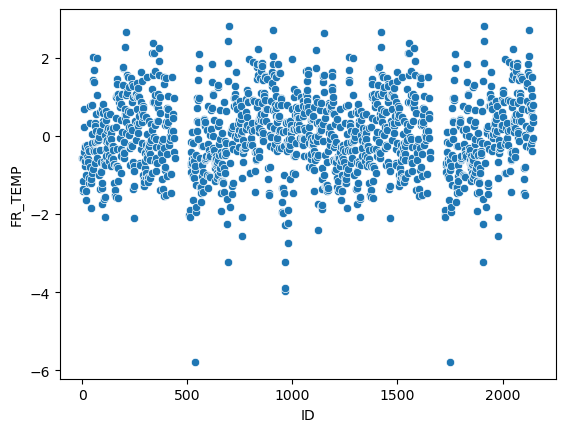

In [4]:
sns.scatterplot(x=df.index, y=df['FR_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

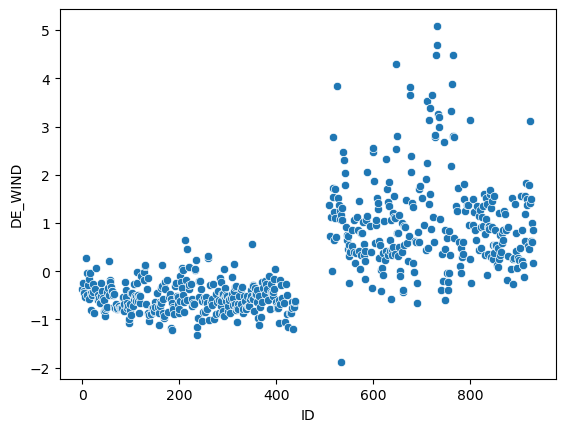

In [5]:
sns.scatterplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

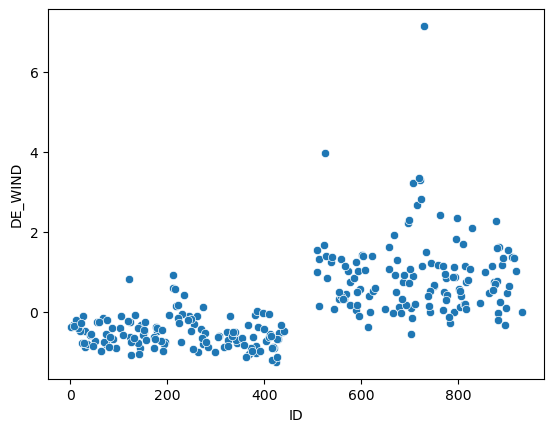

In [6]:
sns.scatterplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

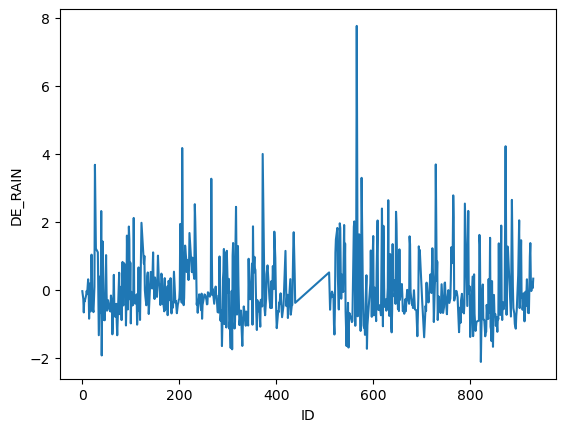

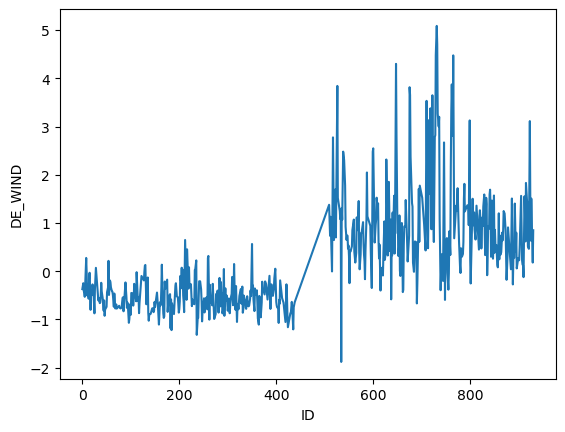

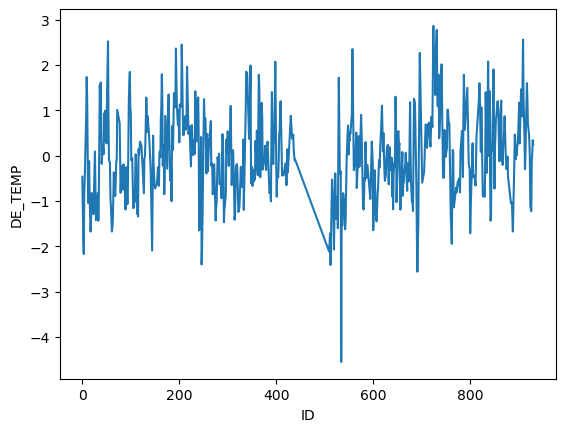

In [7]:
temp_de = de.copy()
temp_de['TARGET'] = y_de['TARGET']
for w in ['RAIN', 'WIND', 'TEMP']:
    plt.figure()
    sns.lineplot(x=temp_de.index, y=temp_de[f'DE_{w}'])

### 24 Hour Rain Forecasting

In [241]:
country_rain = 'FR_TEMP'
df_rain = full_de[country_rain].copy()

# make all rain positive for gamma regressor
de_rain_offset = abs(df_rain.min()) + 2
df_rain = df_rain + de_rain_offset

# fourier_52 = Fourier(period=50.6, order=1)
fourier_25 = Fourier(period=25, order=3)

# [25.1, 138.2, 194.7, 351.9, 408.4]
extra_fourier = [Fourier(period=i, order=3) for i in [365.25]]

dp = DeterministicProcess(
    constant=True,
    period=52,
    index=df_rain.index,
    order=1,
    fourier=3,
    additional_terms=extra_fourier
)
x_fit = dp.in_sample().loc[:439]
y_fit = df_rain.loc[:439]
ridge = linear_model.Ridge(alpha=3)
ridge.fit(x_fit, y_fit)
y_deseasoned = y_fit - ridge.predict(x_fit)
# plt.clf()
# fig, ax = plt.subplots(2)
# ax[0].set_ylabel('DE_RAIN'), ax[1].set_ylabel('DE_RAIN')
# sns.lineplot(x=x_fit.index, y=y_deseasoned, ax=ax[0])
# sns.lineplot(x=x_fit.index, y=y_fit, ax=ax[1])

In [259]:
x_train = dp.in_sample().loc[:439]
y_train = df_rain.loc[:439]
y_train = y_train - y_train.min() + 0.01
for i in range(1, 3):
    x_train[f'LAG_{i}'] = y_train.shift(i).fillna(y_train.mean())
# x_test['LAG_1'] = y_test.shift(1).fillna(y_test.mean())
de_rain_fit = full_de.loc[:439].drop(['DAY_ID', 'COUNTRY', country_rain], axis=1)
x_train = pd.concat([de_rain_fit, x_train], axis=1)

In [260]:
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)

#### Generalized Linear Model (Gamma Distribution)
Turns out 24 hour rainfall is best modeled by a gamma distribution (as verified below with a KS test)

mape test: 0.3409180147655749
mape train: 0.14435353157213393


<Figure size 640x480 with 0 Axes>

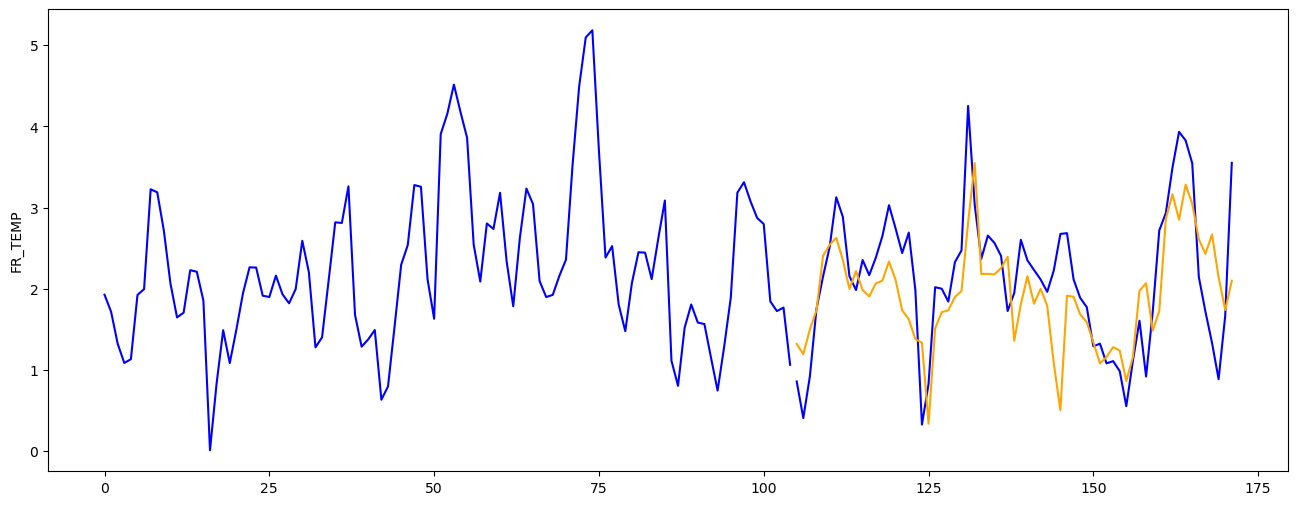

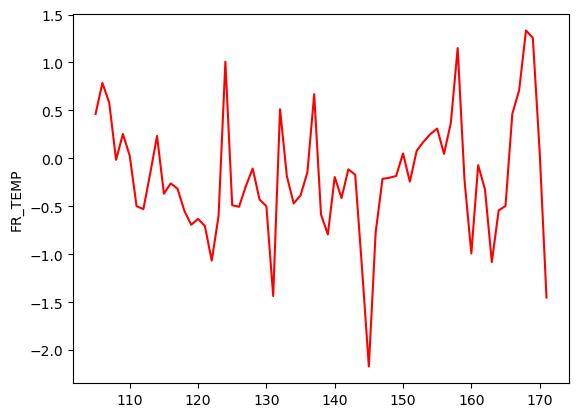

mape test: 0.17356513329364803
mape train: 0.16573832810500294


<Figure size 640x480 with 0 Axes>

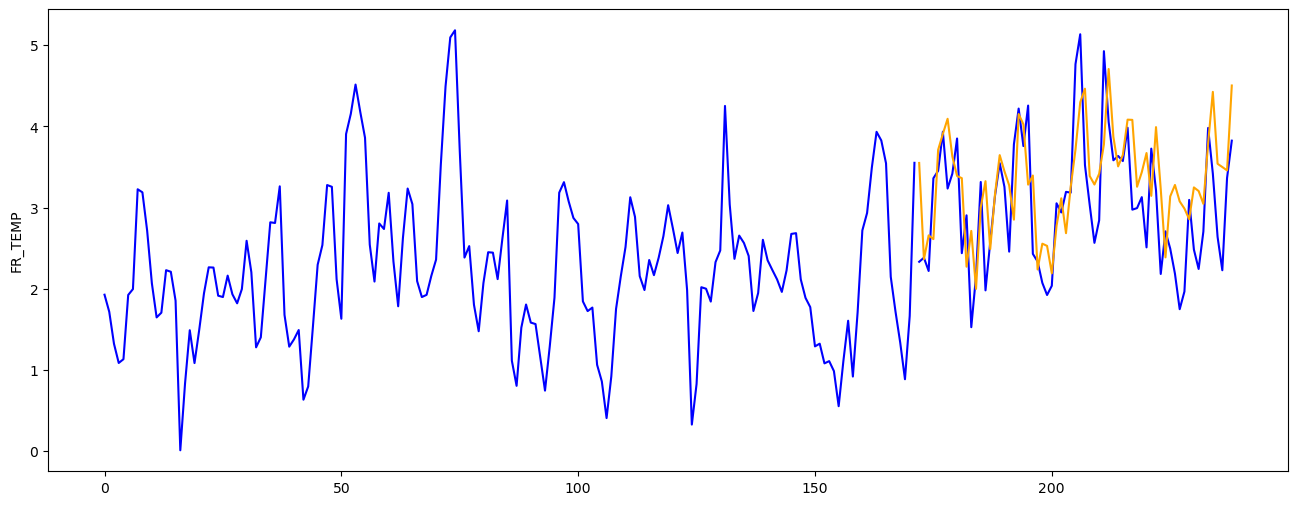

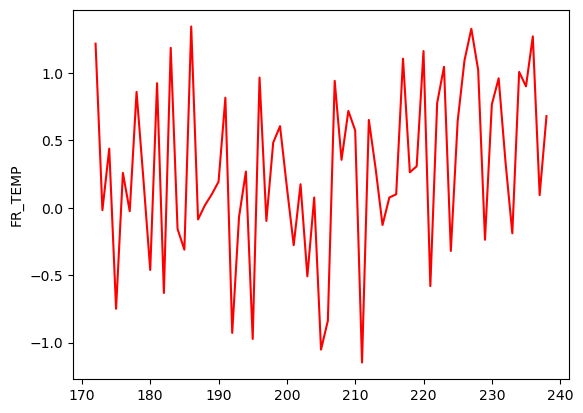

mape test: 0.26548915822457114
mape train: 0.16834289583359857


<Figure size 640x480 with 0 Axes>

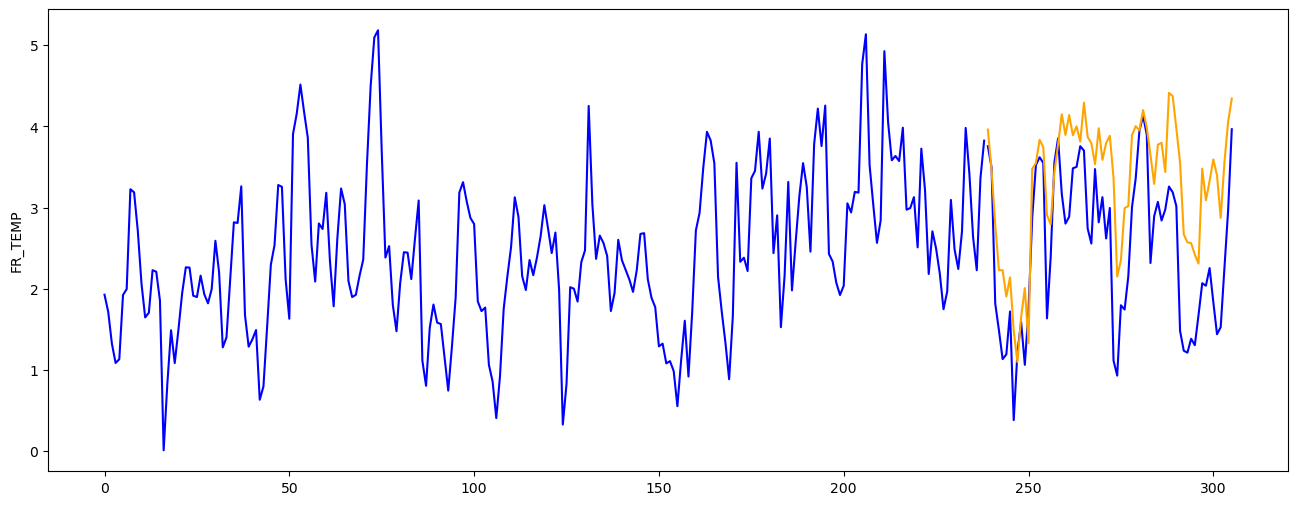

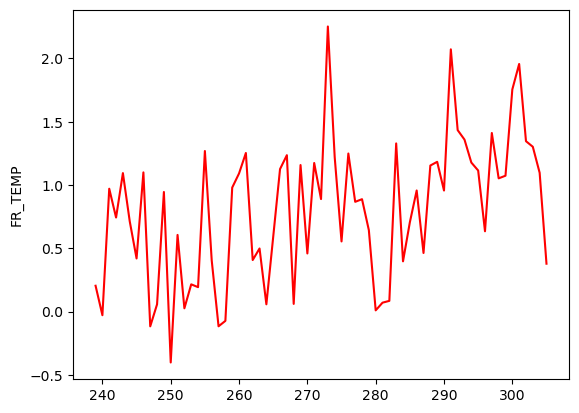

mape test: 0.18806111404602724
mape train: 0.17116484206163127


<Figure size 640x480 with 0 Axes>

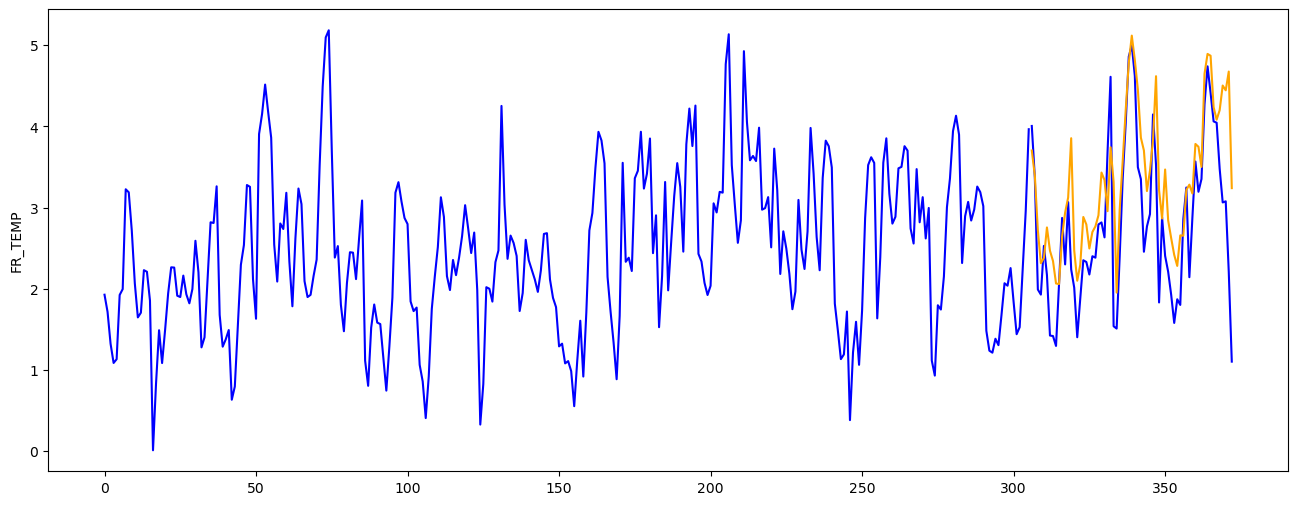

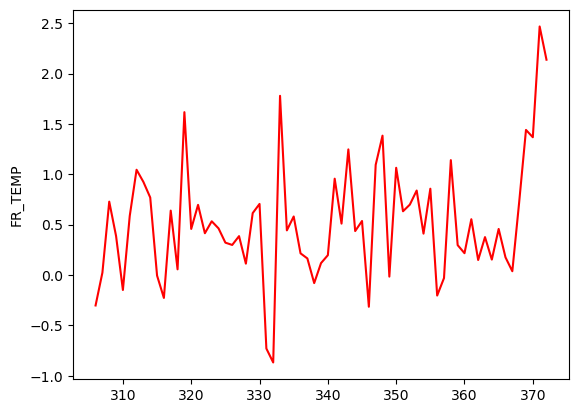

mape test: 0.24847980472191605
mape train: 0.16799875575697162


<Figure size 640x480 with 0 Axes>

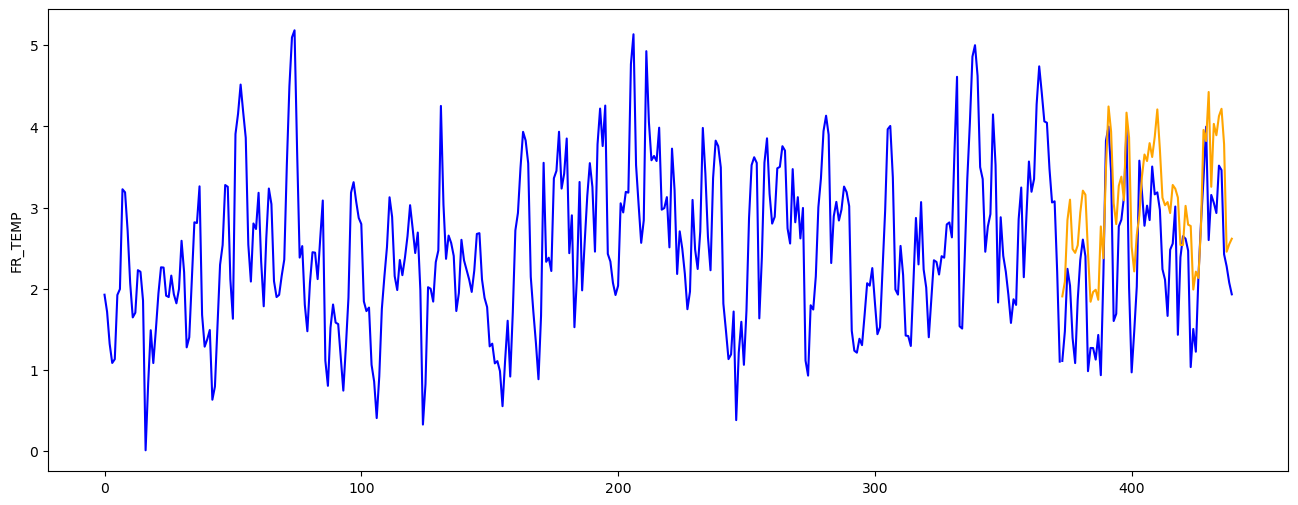

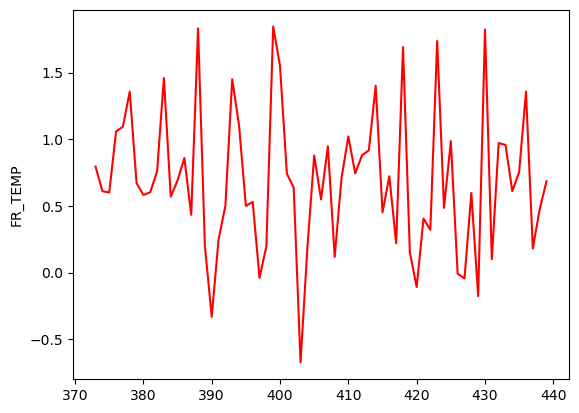

In [261]:
ridge = linear_model.Ridge(alpha=10, fit_intercept=False)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, ridge, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

mape test: 0.3188593786739265
mape train: 0.13840051737977882


<Figure size 640x480 with 0 Axes>

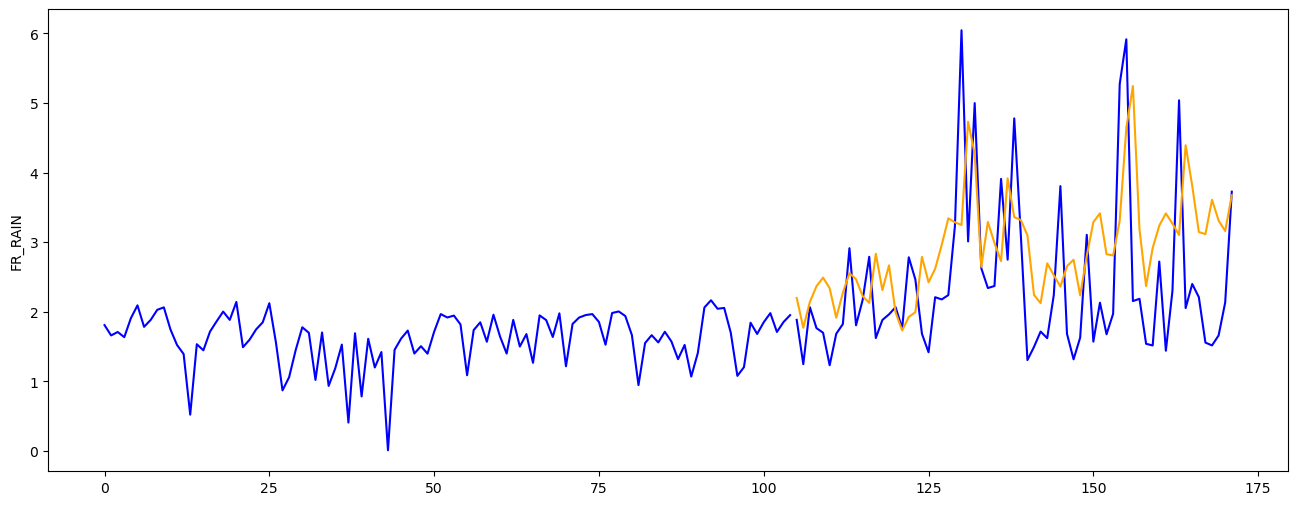

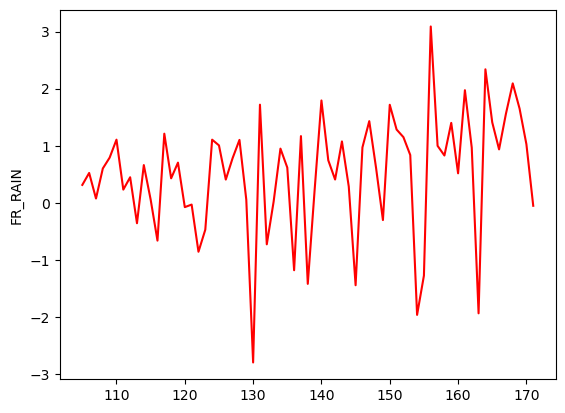

mape test: 0.37255196034239135
mape train: 0.19159322016435157


<Figure size 640x480 with 0 Axes>

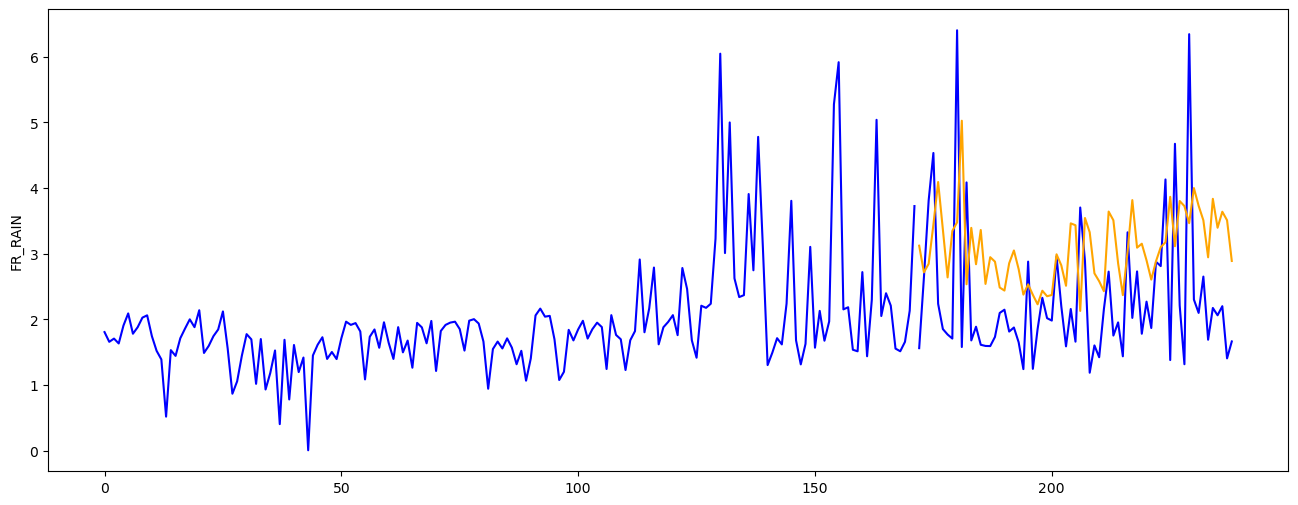

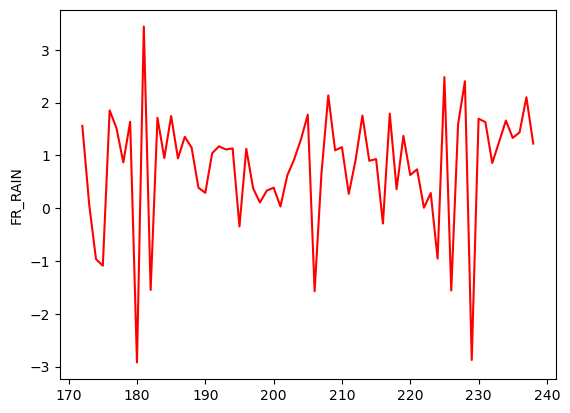

mape test: 0.4061249167257468
mape train: 0.22009998040107853


<Figure size 640x480 with 0 Axes>

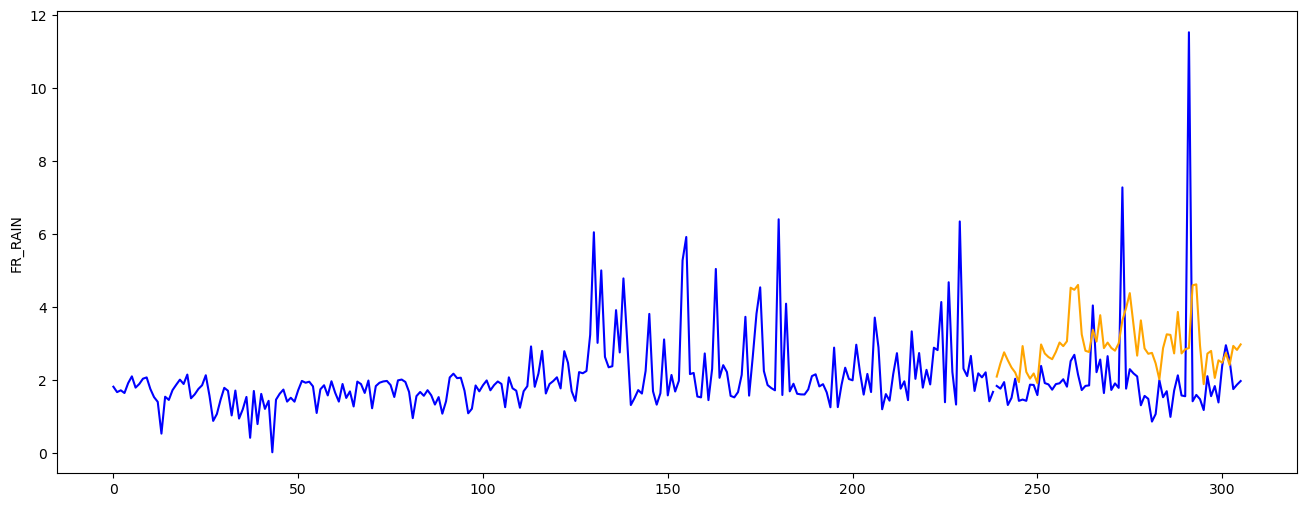

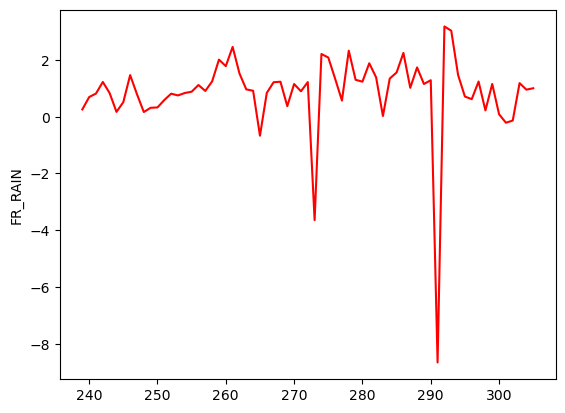

mape test: 0.39162756594239223
mape train: 0.23347628923745836


<Figure size 640x480 with 0 Axes>

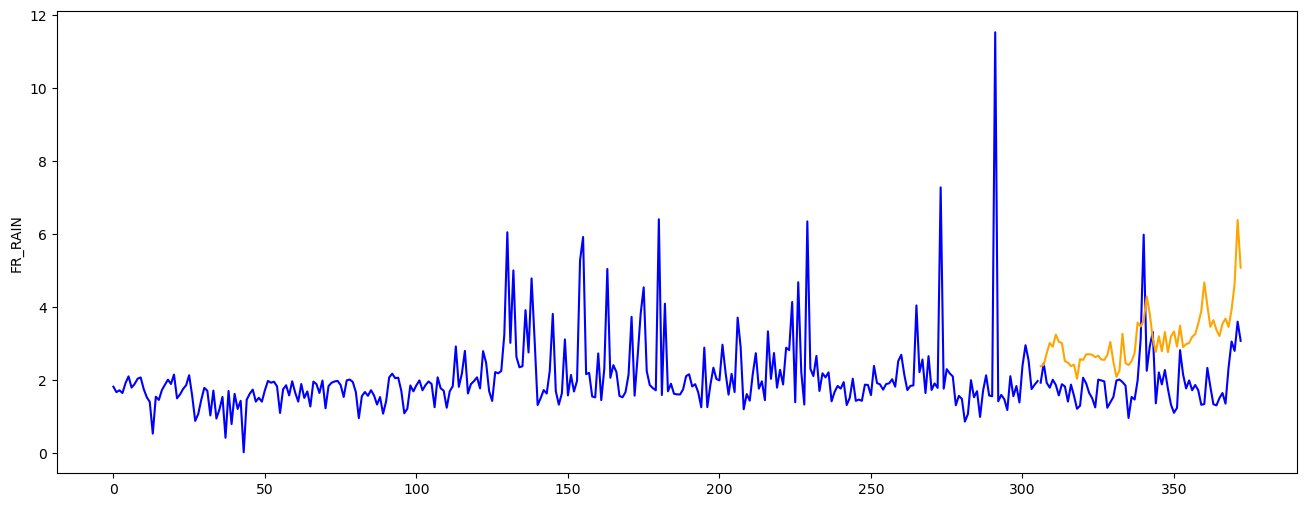

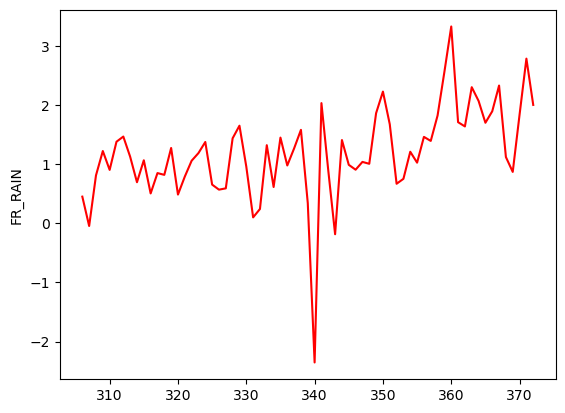

mape test: 0.4795016470822176
mape train: 0.2291537222197505


<Figure size 640x480 with 0 Axes>

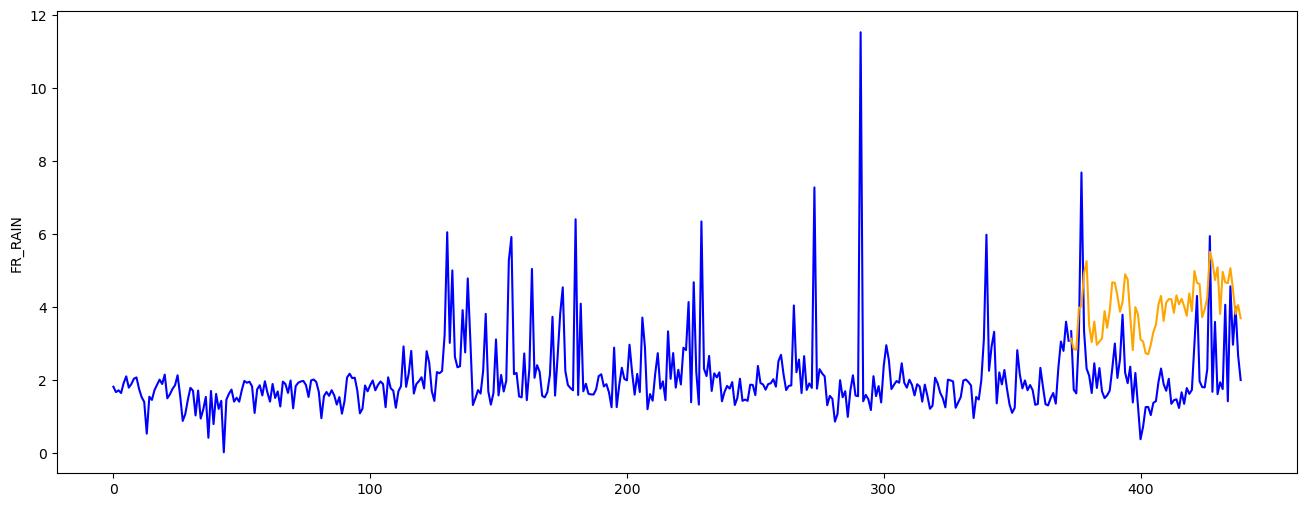

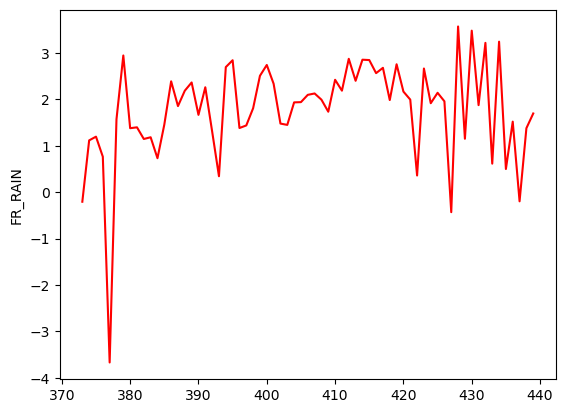

In [200]:
gg = linear_model.GammaRegressor(alpha=0.1, fit_intercept=False)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, gg, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

mape test: 0.3151209456544424
mape train: 0.16981951341429666


<Figure size 640x480 with 0 Axes>

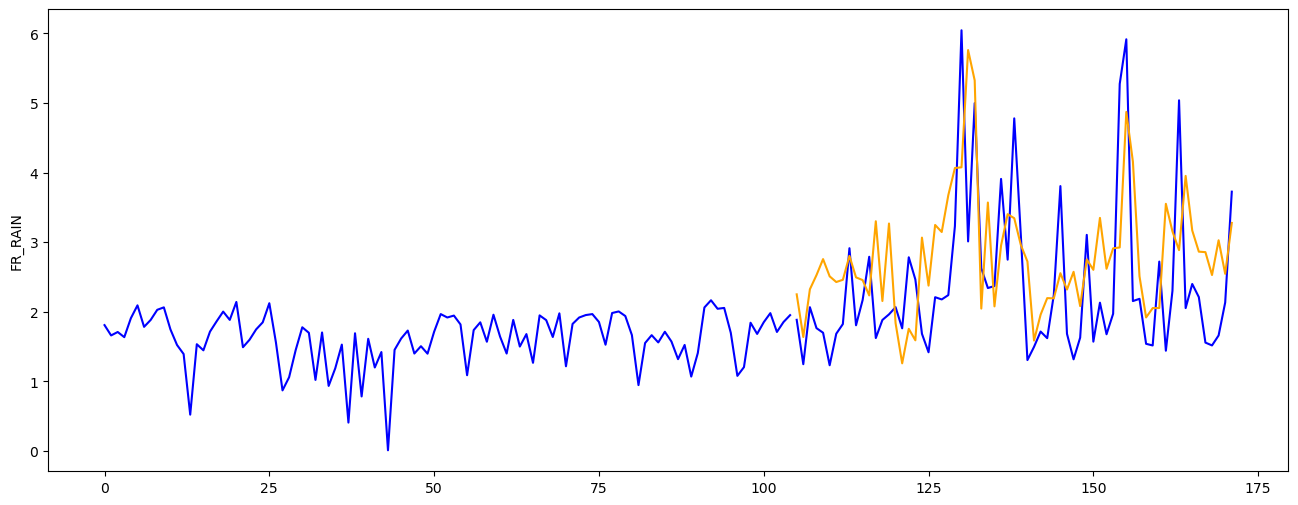

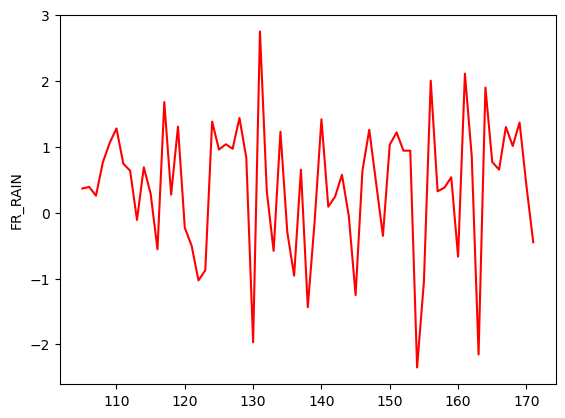

mape test: 0.3350368897885057
mape train: 0.19069421967378822


<Figure size 640x480 with 0 Axes>

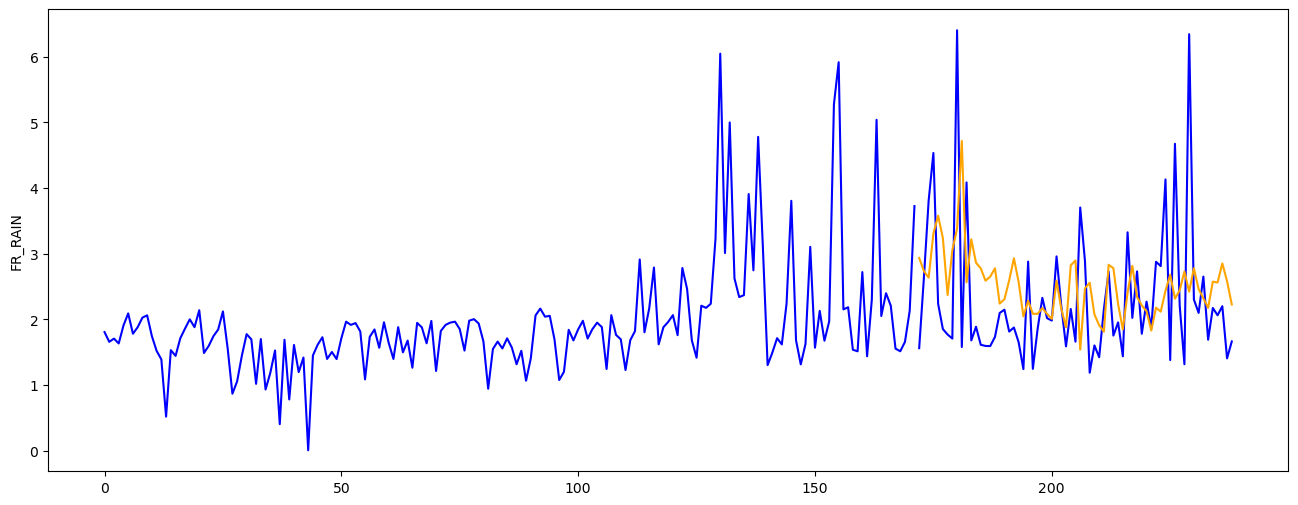

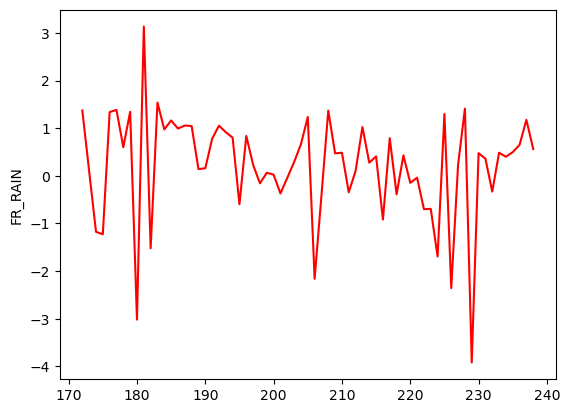

mape test: 0.32131911534122354
mape train: 0.21510938159268345


<Figure size 640x480 with 0 Axes>

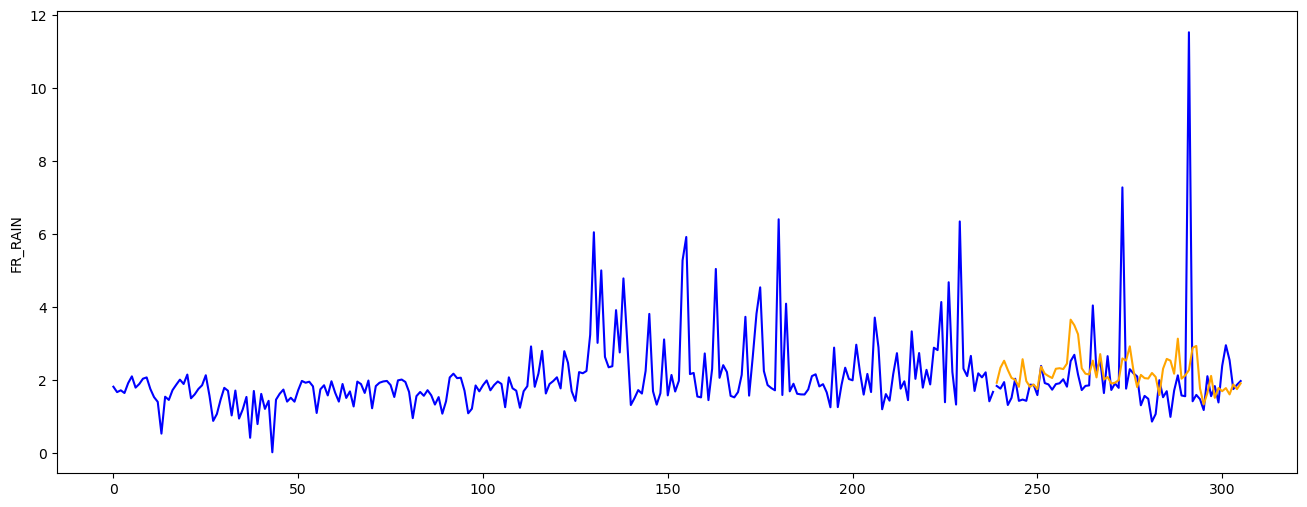

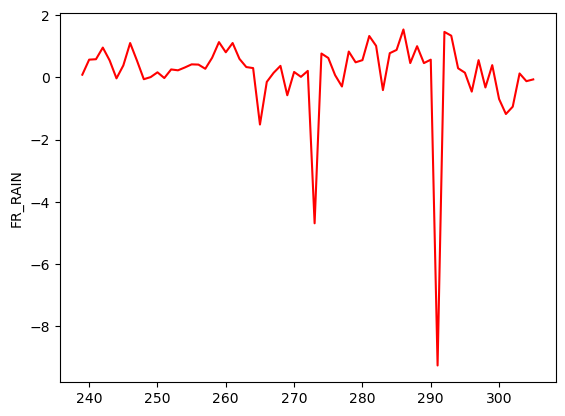

mape test: 0.29563897206055834
mape train: 0.22372051459677572


<Figure size 640x480 with 0 Axes>

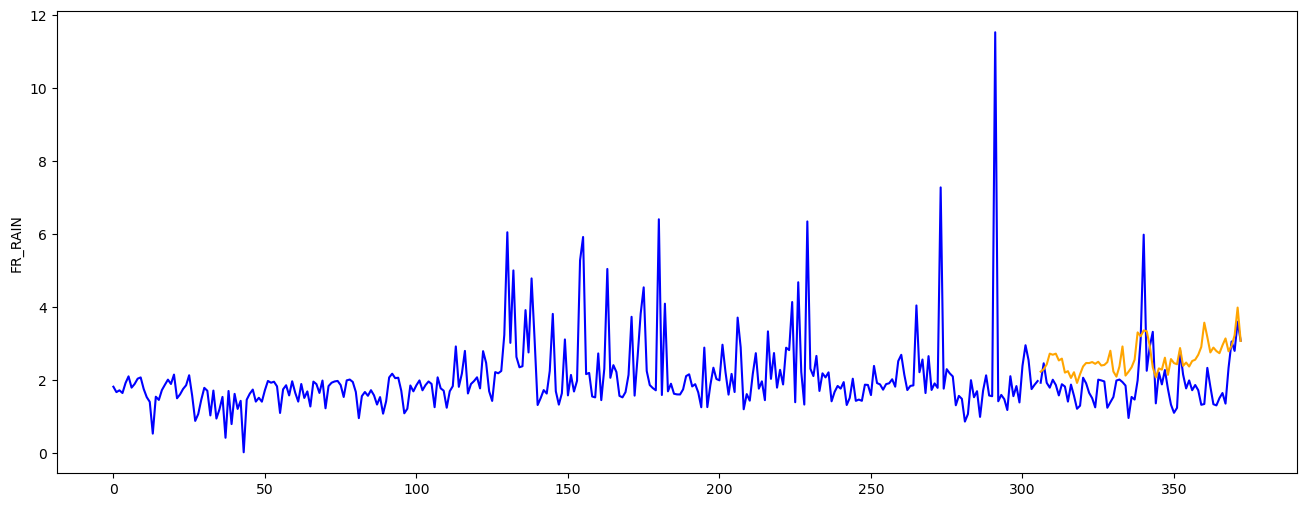

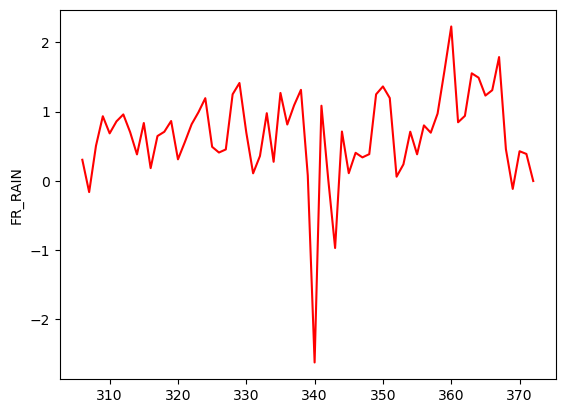

mape test: 0.35632175129270566
mape train: 0.21998459944132737


<Figure size 640x480 with 0 Axes>

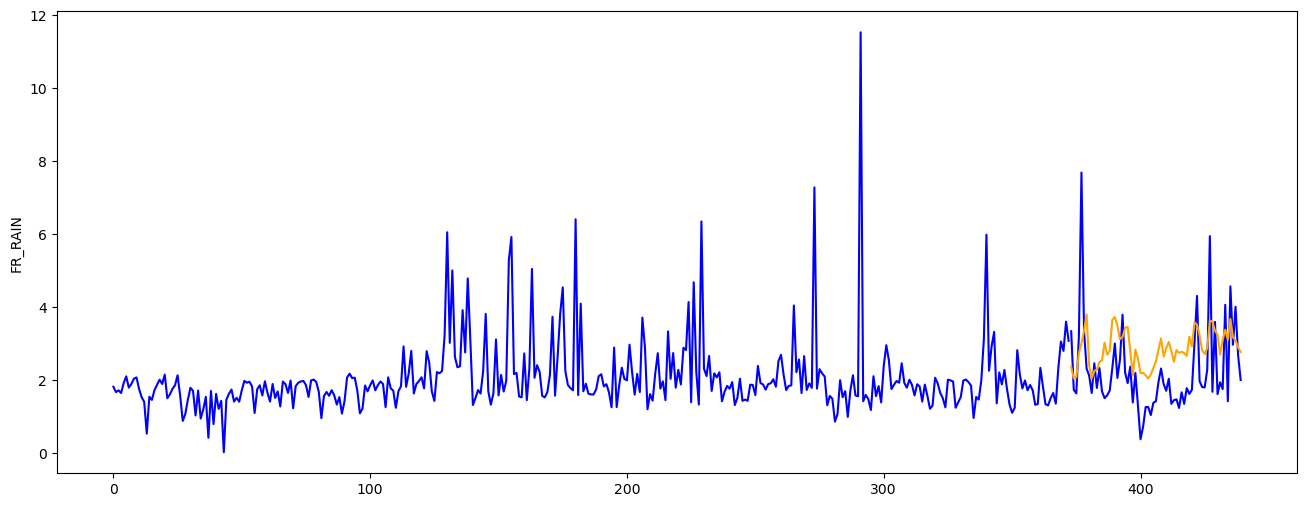

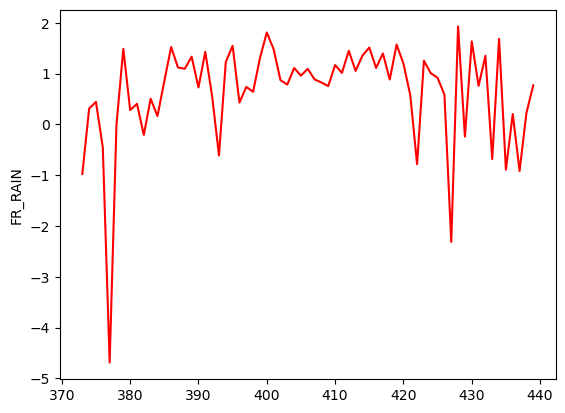

In [237]:
twd = linear_model.TweedieRegressor(power=2.7, alpha=0.08, fit_intercept=True)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, twd, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

In [14]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, objective="reg:gamma", early_stopping_rounds=50)
xgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=10);
# train_output, test_output = test_model(xgb_model, x_train, x_test, y_train, y_test, detailed=True, graph_residuals=True, method='mape')
# test_residual = y_test - test_output
# train_residual = y_train - train_output
# sns.histplot(residual_mod)

NameError: name 'x_test' is not defined

In [ ]:
pd.DataFrame(data=xgb_model.feature_importances_, index=x_train.columns).sort_values(0, ascending=False)

In [ ]:
fs = np.linspace(0.1, 500, 1000)
plt.figure()
    
pgram = signal.lombscargle(x=x_train.index, y=train_output, freqs=fs)
print([fs[i] for i in np.argwhere(pgram > 25).ravel()])
p_de = sns.lineplot(x=fs, y=pgram)
p_de.set(xlabel='train')

plt.show()
plt.figure()

pgram = signal.lombscargle(x=x_test.index, y=test_output, freqs=fs)
print([fs[i] for i in np.argwhere(pgram > 25).ravel()])
p_de = sns.lineplot(x=fs, y=pgram)
p_de.set(xlabel='test')

plt.show()

In [ ]:
gg = linear_model.GammaRegressor(alpha=0.2)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=5)
train_output, test_output = test_model(gg, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, graph_residuals=True, method='mape')

In [ ]:
gg = linear_model.GammaRegressor(alpha=0.2)
kf = KFold(n_splits = 5)
kf_test_model(kf, gg, x_train, y_train, wind_excess=False, target_col=None, graph_residuals=True, method='mape')

In [ ]:
plt.clf()
fig, ax = plt.subplots(2)
print(mape(y_train, gg.predict(x_train)))
print(mape(y_test, gg.predict(x_test)))
sns.lineplot(x=y_train.index, y=y_train, ax=ax[0])
sns.lineplot(x=y_train.index, y=gg.predict(x_train), ax=ax[0])
sns.lineplot(x=y_test.index, y=y_test, ax=ax[1])
sns.lineplot(x=y_test.index, y=gg.predict(x_test), ax=ax[1])

In [ ]:
de

In [ ]:
cols = pd.DataFrame(de.drop(['COUNTRY'], axis=1).columns)
for w in ['RAIN', 'WIND', 'TEMP']:
    cols[f'MI_FR_{w}'] = mir(X=de.drop(['COUNTRY'], axis=1).dropna(), y=de[f'FR_{w}'].dropna())
cols

In [ ]:
fs = np.linspace(0.1, 500, 1000)
for col in weather_vars:
    plt.figure()
    fig, axs = plt.subplots(2)
    
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_fr = sns.lineplot(x=fs, y=pgram, ax=axs[0])
    p_fr.set(xlabel=f'{col} for FR')
    
    pgram = signal.lombscargle(x=de[col].dropna().index, y=de[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 5).ravel()])
    p_de = sns.lineplot(x=fs, y=pgram, ax=axs[1])
    p_de.set(xlabel=f'{col} for DE')
    
    plt.show()

In [ ]:
de.count()

In [ ]:
df_weather = country_flow(fourier_features(de)).drop(['DAY_ID', 'COUNTRY'], axis=1)

weather_train = df_weather[df_weather['DE_RAIN'].notna()]
weather_test = df_weather[df_weather['DE_RAIN'].isna()]

y = weather_train[['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP']]
weather_train = weather_train.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)
weather_test = weather_test.drop(['DE_WIND', 'DE_RAIN', 'DE_TEMP', 'FR_WIND', 'FR_RAIN', 'FR_TEMP'], axis=1)

### Feature Engineering

In [ ]:
y

### Models

In [ ]:
x = lag_shift(weather_train, np.arange(3))
target = y
curr = 'FR_TEMP'
# de: ridge alpha 40, xgb gamma 25

In [ ]:
weather_train

In [ ]:
# x = (x - x.mean()) / x.std()

In [ ]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target[curr], test_size=0.33, random_state=88, shuffle=False)

#### Baseline Linear Regression

In [ ]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

#### Ridge Regression

In [ ]:
ridge = linear_model.Ridge(alpha=0.1)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

#### XGB Regression

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=10)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

In [ ]:
kf = KFold(n_splits = 5, shuffle=True)
kf_test_model(kf, xgb_model, x, target, wind_excess=False, target_col=curr)

#### Ridge Regression - XGB Hybrid

In [ ]:
ridge = linear_model.Ridge(alpha=0.1)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=6.8)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

### Output

In [218]:
weather_forecast = full_de[full_de['DE_WIND'].isna()][weather_vars]

#### RAIN

mape test: 0.3151209456544424
mape train: 0.16981951341429666


<Figure size 640x480 with 0 Axes>

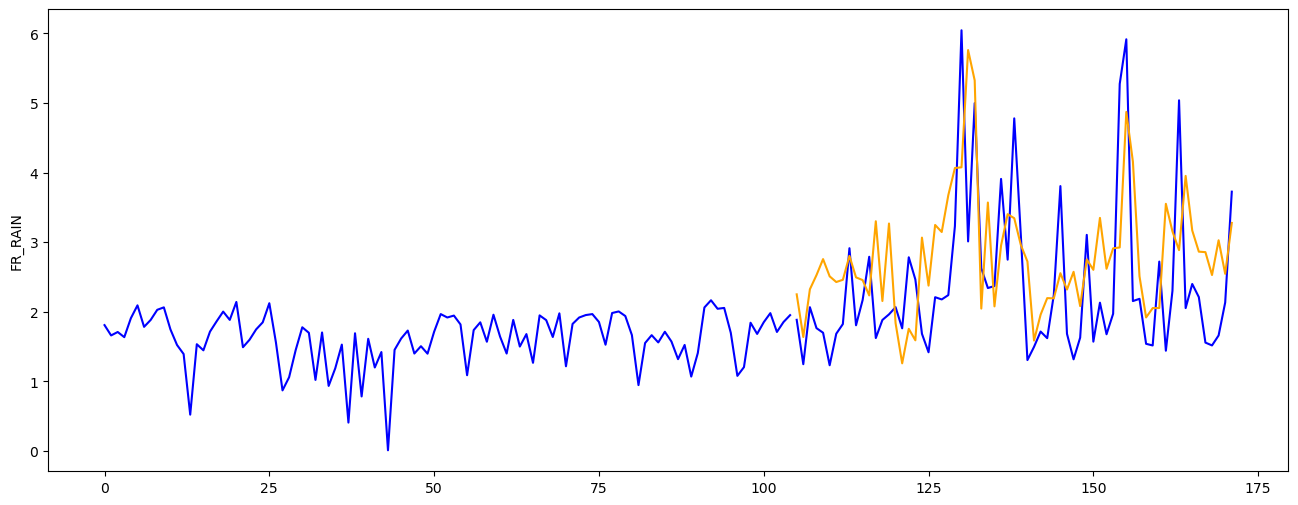

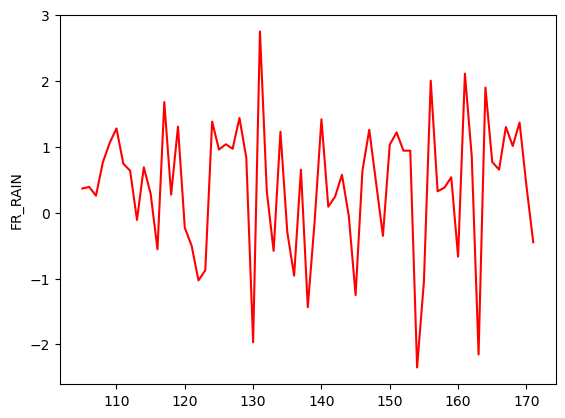

mape test: 0.3350368897885057
mape train: 0.19069421967378822


<Figure size 640x480 with 0 Axes>

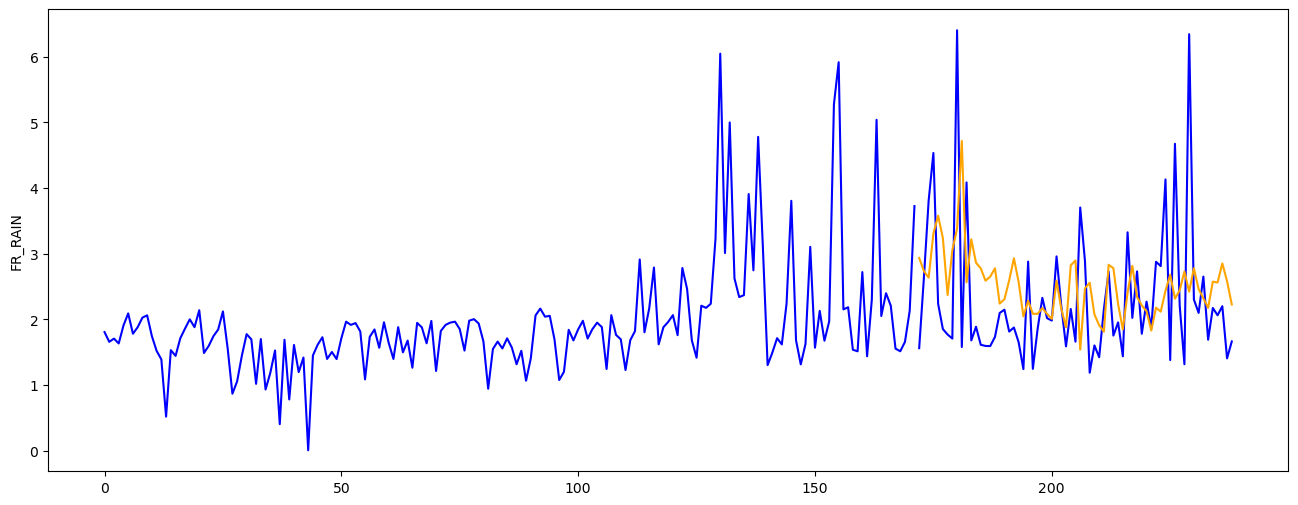

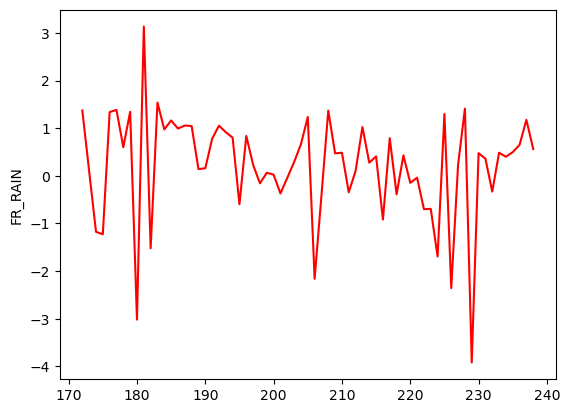

mape test: 0.32131911534122354
mape train: 0.21510938159268345


<Figure size 640x480 with 0 Axes>

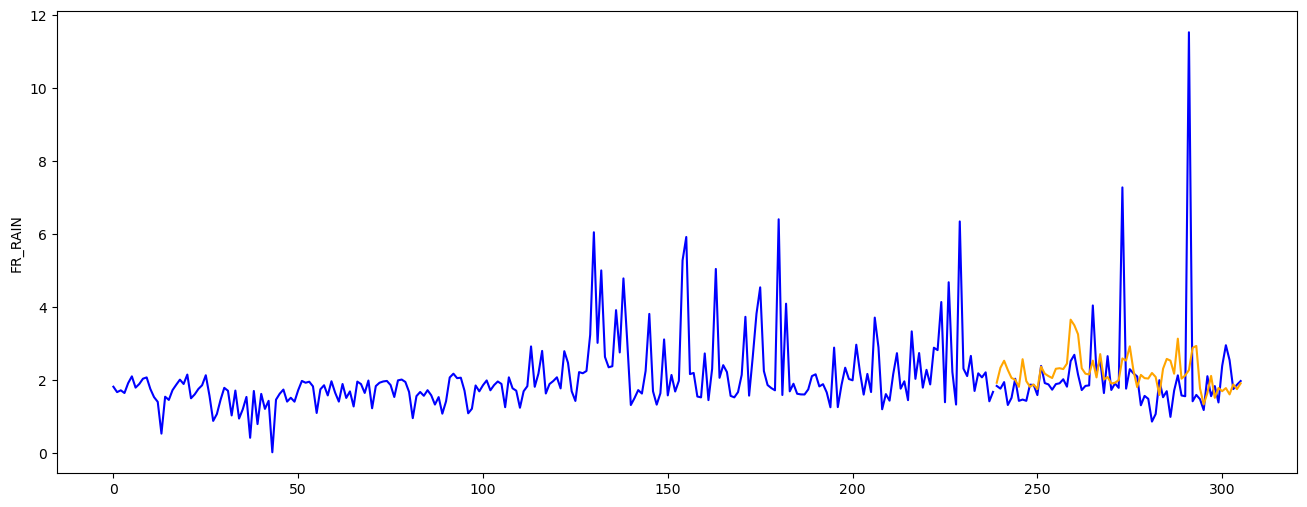

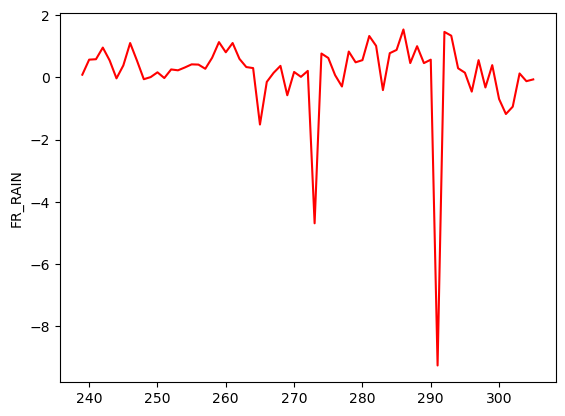

mape test: 0.29563897206055834
mape train: 0.22372051459677572


<Figure size 640x480 with 0 Axes>

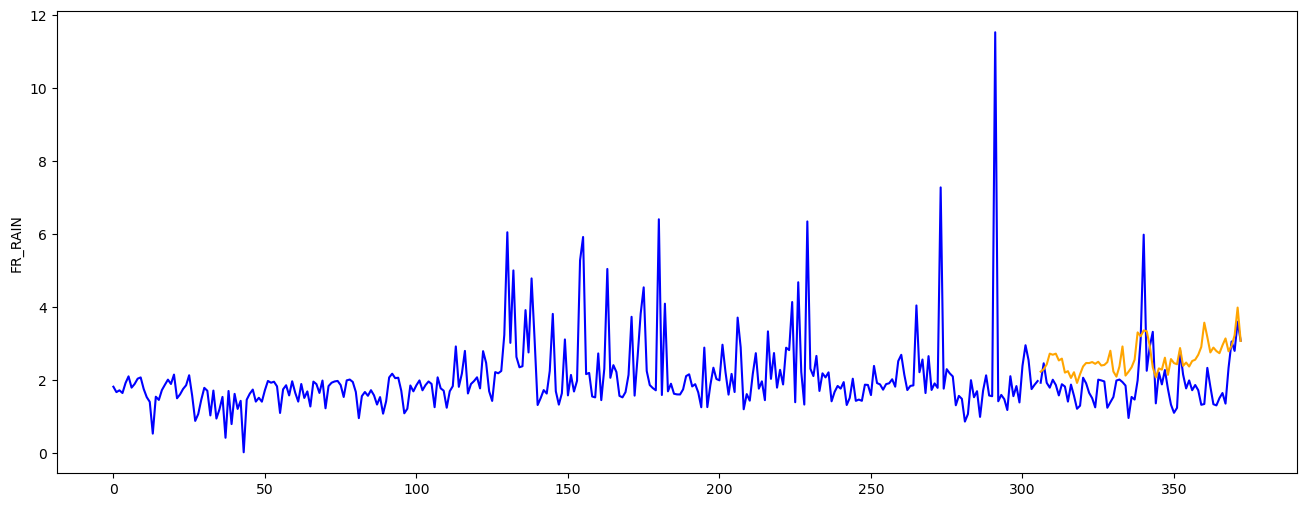

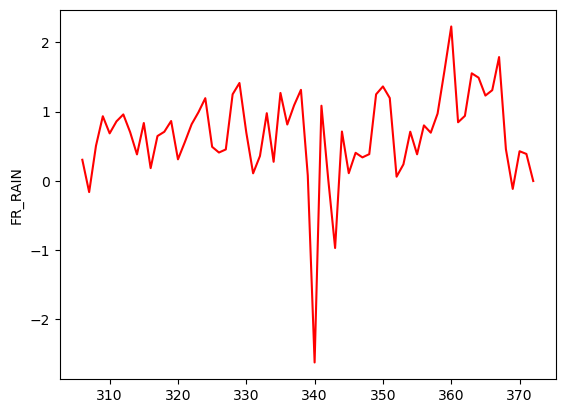

mape test: 0.35632175129270566
mape train: 0.21998459944132737


<Figure size 640x480 with 0 Axes>

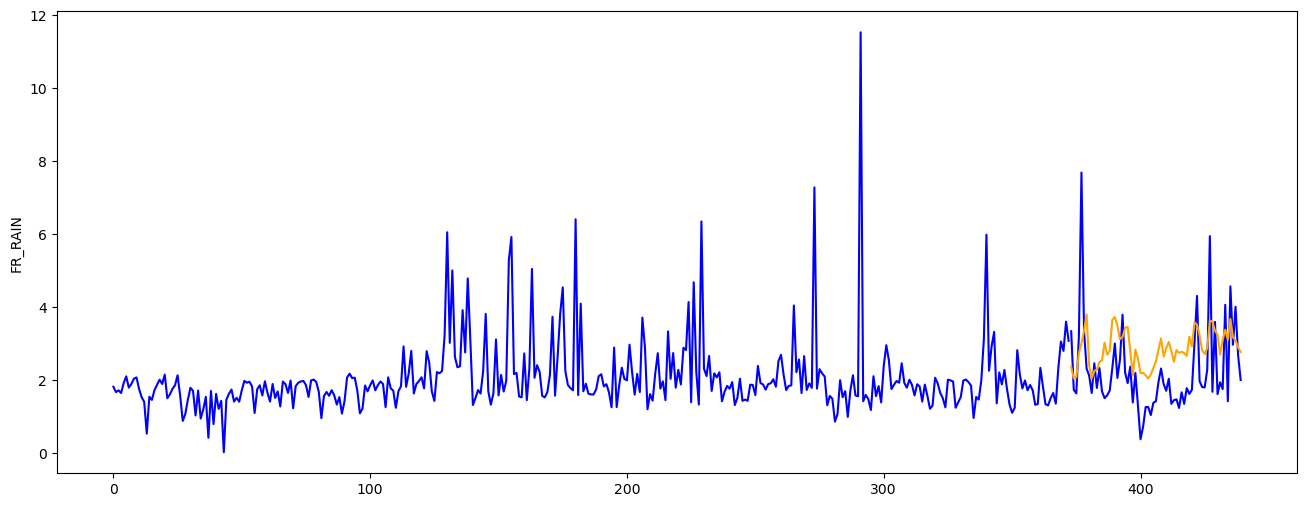

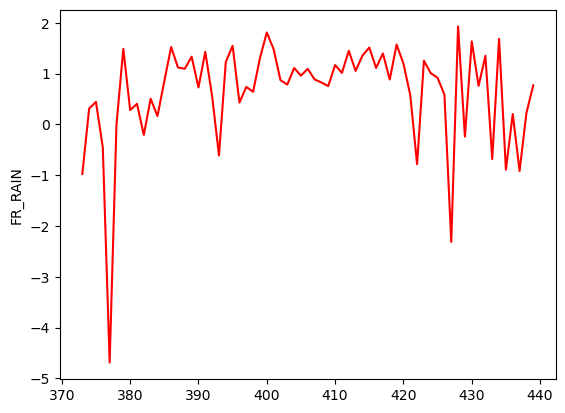

In [239]:
# FR, LAG 5 (to be tuned)
twd = linear_model.TweedieRegressor(power=2.7, alpha=0.08, fit_intercept=True)
tss = TimeSeriesSplit(n_splits=5, max_train_size=None, test_size=67)
time_series_test(tss, twd, x_train, y_train, wind_excess=False, graph_residuals=True, method='mape')

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=3)
xgb_model.fit(weather_train, y['DE_WIND'])
weather_forecast['DE_WIND'] = xgb_model.predict(weather_test)

In [ ]:
pd.DataFrame(data=xgb_model.feature_importances_, index=weather_train.columns).sort_values(0, ascending=False)

#### TEMP

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=0.5)
xgb_model.fit(weather_train, y['FR_WIND'])
weather_forecast['FR_WIND'] = xgb_model.predict(weather_test)

In [ ]:
weather_forecast

<Axes: xlabel='ID', ylabel='DE_WIND'>

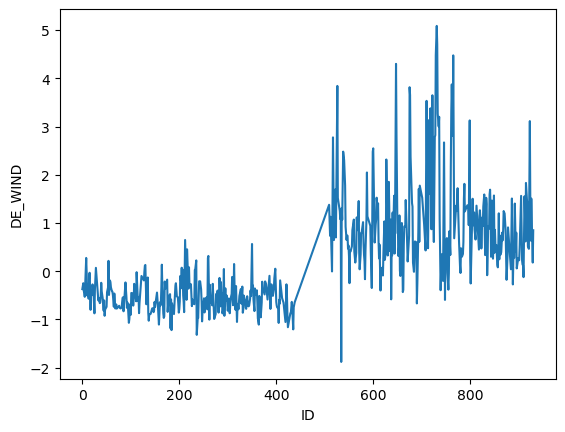

In [224]:
de_wind = de[de['DE_WIND'].notna()]['DE_WIND'].append(weather_forecast['DE_WIND']).sort_index()
sns.lineplot(x=de_wind.index, y=de_wind)

<Axes: xlabel='ID', ylabel='FR_WIND'>

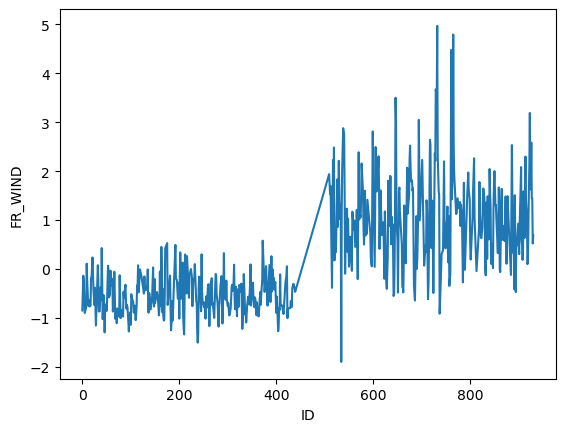

In [223]:
fr_wind = de[de['FR_WIND'].notna()]['FR_WIND'].append(weather_forecast['FR_WIND']).sort_index()
sns.lineplot(x=fr_wind.index, y=fr_wind)